# Tutorial 2.3: Analyzing Application-Layer Protocols

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under_Construction&color=orange)


**Open notebook on:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial2_anomaly_detection/tutorial2_anomaly_detection.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial2_anomaly_detection/tutorial2_anomaly_detection.ipynb)   
**Author:** Christoph R. Landolt


In this tutorial, we transition from analyzing generic network traffic (e.g., KDD Cup 99) to focusing specifically on **threats targeting web applications**.  
Web applications form the backbone of modern digital services, yet they are also among the most exposed components in a networked system. Attacks such as **SQL Injection (SQLI)**, **Cross-Site Scripting (XSS)**, and **Parameter Tampering** exploit vulnerabilities in **application-layer logic** rather than low-level network protocols.

The **CSIC 2010 Web Application Attacks Dataset** is a benchmark corpus developed by the **Spanish Research National Council (CSIC)** for evaluating **Web Application Firewalls (WAFs)** and **Intrusion Detection Systems (IDSs)** designed to protect web services.  
It provides labeled HTTP traffic directed at a simulated e-commerce web application.  
Because the dataset contains both **normal** and **malicious** HTTP requests, it is ideal for **anomaly detection** approaches that learn patterns of legitimate web behavior and flag deviations as potential attacks.


## Tutorial Objectives
By the end of this tutorial, you will be able to:
- Describe the structure and purpose of the CSIC 2010 dataset.  
- Explain key categories of web application attacks (SQLI, XSS, parameter tampering, etc.).  
- Load and preprocess HTTP request data for anomaly detection.  
- Visualize dataset distributions (normal vs. attack).  
- Prepare the dataset for model-based anomaly detection (covered in the following tutorial).


## Dataset Composition and Anomalies

The CSIC 2010 dataset consists of approximately:

- **36,000 normal** HTTP requests  
- **25,000 anomalous** HTTP requests  

All requests are synthetically generated and labeled, with attacks crafted using penetration-testing tools such as **Paros** and **W3AF**.  

### Attack Categories

| Attack Type | Description |
|--------------|-------------|
| **SQL Injection (SQLI)** | Exploiting input-validation flaws to manipulate backend SQL queries. |
| **Cross-Site Scripting (XSS)** | Injecting malicious JavaScript or HTML into web pages viewed by other users. |
| **Parameter Tampering** | Modifying GET/POST parameters or cookies to alter application logic. |
| **Buffer Overflow** | Sending oversized payloads that overflow memory buffers. |
| **Information Gathering** | Attempting to extract server or application information (e.g., file disclosure, directory traversal). |
| **CRLF Injection** | Inserting carriage-return/line-feed sequences to split HTTP responses. |
| **Unintentional Illegal Requests** | Abnormal requests violating expected application behavior without explicit malicious intent. |

These categories together provide a rich and realistic evaluation environment for modern web-security models.



## Data Structure and Features

Each record in the dataset corresponds to **one HTTP request**, parsed into multiple features representing different components of the request:

| Feature Category | Example Features | Description |
|------------------|------------------|--------------|
| **Request Metadata** | `method`, `url`, `protocol` | Basic request-line info (e.g., GET, POST, HTTP/1.1). |
| **Request Headers** | `userAgent`, `host`, `cookie`, `contentType`, `accept`, `connection` | Client and session header fields. |
| **Request Content** | `contentLength`, `payload` | Body length and content; often the attack vector. |
| **Target Label** | `label` or `classification` | Ground-truth class: *Normal* or *Anomalous*. |

The **feature-engineering challenge** lies in encoding categorical headers and extracting meaningful representations from text-heavy fields such as `url` and `payload`, which frequently contain obfuscated attack patterns.


## Structure of an HTTP Request

To analyze the CSIC 2010 dataset and detect attacks at the protocol level, it is essential to understand the basics of an HTTP request.  

An HTTP request is the message sent by a client (for example, a web browser or an application) to a server in order to request data or perform an operation. It consists of several parts, each serving a specific function.
An HTTP request has the following general structure:

<img src="./HTTP_request.png" alt="HTTP Request Structure" width="650"/>

Let’s break down the components step by step.

### Method

Originally, the HTTP protocol was designed as an interface for distributed object systems and therefore allowed a wide variety of [*method tokens*](https://www.iana.org/assignments/http-methods/http-methods.xhtml#methods). With the introduction of REST systems, the available methods were standardized in [**RFC 7231**](https://datatracker.ietf.org/doc/html/rfc7231).  

Every system **must support** at least the two methods **GET** and **HEAD**, while all other methods are **optional**.  
All standardized HTTP methods must be registered with the [**IANA** (Internet Assigned Numbers Authority)](https://www.iana.org/).

In this tutorial, since the CSIC 2010 dataset is based on RESTful services, we will focus only on the following methods:

| Method | Description |
|--------|--------------|
| **GET** | Retrieves data from the server. |
| **POST** | Sends new data to the server. |
| **PUT** | Replaces an existing resource with new data. |
| **PATCH** | Partially updates an existing resource. |
| **DELETE** | Removes a resource from the server. |
| **HEAD** | Same as GET, but retrieves only the headers, not the body. |

### Request URI and Query String

The **Request URI (Uniform Resource Identifier)** specifies the resource that the client wants to access.  

Optionally, a **Query String** can be appended to the URI to send additional key–value pairs to the server. This mechanism is defined in [**RFC 3986**](https://datatracker.ietf.org/doc/html/rfc3986).
The query string begins after a **question mark (`?`)**, and multiple key–value pairs are separated by an **ampersand (`&`)**.

**Example:**
```
test.php?key1=value1&key2=value2
```
Here:
- `test.php` → the target resource (URI)  
- `key1=value1&key2=value2` → the query string with two parameters

### HTTP Header

The HTTP header is a section where the client can provide metadata about itself or about the request. Standard header fields are defined in [**RFC 2616**](https://datatracker.ietf.org/doc/html/rfc2616), but developers can also add custom fields. If the server does not support a specific header field, it simply ignores it.

Each header line follows this structure:
```
Key: Value
```
and ends with a **carriage return and line feed (CRLF)**.

**Example:**
```
Content-Type: application/json
User-Agent: Mozilla/5.0
```

#### HTTP Body

The HTTP body is separated from the header by an empty line (CRLF). It contains the **data payload** of the request—this is where the client sends information to the server (for example, form data, JSON, XML, or files). The **format of the data** depends on the target endpoint and is specified in the header field **`Content-Type`**.

**Example:**
```
Content-Type: application/json
```
```json

{
"username": "alice",
"password": "1234"
}
```

## Data Loading and Integration

The dataset is typically provided as a collection of CSV files, each representing a traffic capture or session.  
The first step is to load all files into a single `pandas` DataFrame for preprocessing.


In [69]:
import os
import pandas as pd
from glob import glob
# Jupyter cell
FILE = "csic-2010-web-application-attacks.zip"
DIR = "csic-2010-web-application-attacks"
URL = "https://www.kaggle.com/api/v1/datasets/download/ispangler/csic-2010-web-application-attacks"

# Download if not exists
if not os.path.isfile(FILE):
    print(f"Downloading {FILE}...")
    !curl -L -o {FILE} {URL}
else:
    print(f"{FILE} already exists, skipping download.")

# Unzip if not exists
if not os.path.isdir(DIR):
    print(f"Unzipping {FILE}...")
    !unzip -q {FILE} -d {DIR}
else:
    print(f"{DIR} already exists, skipping unzip.")

# Load all CSV files in the dataset folder into a single DataFrame
csv_files = glob(os.path.join(DIR, "*.csv"))
dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Show the first rows
df.head()

csic-2010-web-application-attacks.zip already exists, skipping download.
csic-2010-web-application-attacks already exists, skipping unzip.


,Unnamed: 0,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


In [70]:
df.columns

Index(['Unnamed: 0', 'Method', 'User-Agent', 'Pragma', 'Cache-Control',
       'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host',
       'cookie', 'content-type', 'connection', 'lenght', 'content',
       'classification', 'URL'],
      dtype='object')

In [71]:
df = df.rename(columns={'Unnamed: 0': 'label'})


In [72]:
df.head()

,label,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


### Exploratory Analysis

Class distribution:
label
Normal       36000
Anomalous    25065
Name: count, dtype: int64


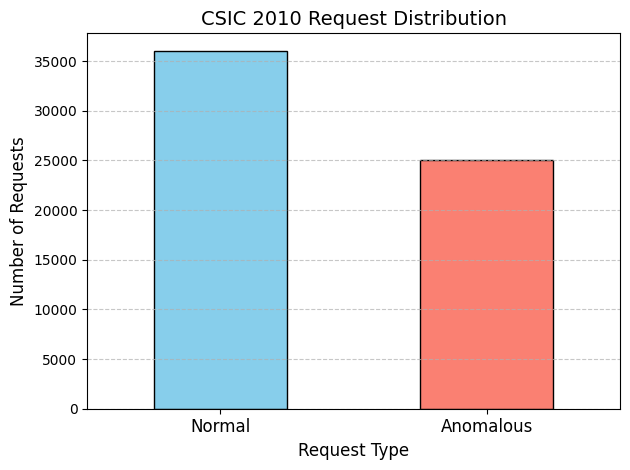

In [73]:
import matplotlib.pyplot as plt

# Count class distribution
label_counts = df['label'].value_counts()

# Print numeric summary
print("Class distribution:")
print(label_counts)

# Plot
ax = label_counts.plot(
    kind='bar',
    color=['skyblue', 'salmon'],
    edgecolor='black'
)
plt.title("CSIC 2010 Request Distribution", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.xlabel("Request Type", fontsize=12)
plt.ylabel("Number of Requests", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## DATA PRE-PROCESSING

### Step 1: Clean Data
Remove or process invalid patterns/columns, missing values, or redundancies to ensure clean data.

In [74]:
# Implement data pre-processing steps

## Attack detection usin classic ML methods
In this section well use manual Feature engineering to train an Isolation Forest...

In [75]:
# Implement Feature Engineering steps here
# For example, extracting URL length, presence of SQL keywords, etc.

## Natural Language Processing (NLP) for Protocol-Level Feature Engineering

In this section, we pivot from classic machine learning methods that rely on hand-crafted features (like URL length, count of special characters) to a deep learning approach using **BERT (Bidirectional Encoder Representations from Transformers)**. This method allows the model to automatically learn rich, contextualized features directly from the raw text payloads, often capturing subtle, obfuscated attack patterns that manual feature engineering might miss.

We will use the BERT embeddings as the input for a simple, fully connected **Neural Network (NN)** to perform the final attack classification.

### Introduction to NLP and BERT

**Natural Language Processing (NLP)** is the field of AI focused on interpreting human language. In web security, we treat the text within HTTP requests (URLs, parameters, payloads) as the "language" to be scrutinized for malicious grammar.

**BERT** is a pre-trained language model that processes text bidirectionally, considering the entire context of a sequence. For a web attack detector, BERT is vital because it can:

*   **Understand Attack Context:** It assigns unique vector embeddings to tokens like `'SELECT'`, `'UNION'`, or `'<script>'`, capturing their semantic and contextual roles in a malicious payload.
*   **Generate High-Quality Features:** It converts the raw input string into a sequence of fixed-size, informative vectors, which form the feature set for our classifier.

*(Note: The following implementation uses the separate, pre-cleaned `HttpParams` dataset to train the model, as the `content` and `URL` fields of CSIC require complex, multi-step concatenation and cleaning which is done in the preprocessing steps not fully shown here.)*

### Step 1: Importing Required Libraries

We import all necessary libraries, including PyTorch for the Neural Network, Hugging Face Transformers for BERT, and scikit-learn for data preparation and evaluation.


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from urllib.parse import urlparse, parse_qs, unquote
# Deep learning model imports
from torch.nn import Conv1d, MaxPool1d, Linear, BatchNorm1d
import seaborn as sns

In [77]:
# Checking and Using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Step 2: BERT Feature Extraction
We load the `bert-base-uncased` model and use it to extract features from the web attack payloads. We assume the `df` (subsampled version) is already available and preprocessed.

In [78]:
# Create a new column 'combined_payload' by concatenating URL and Content.
# Fill NaN values in 'content' with an empty string for safe concatenation.
df['combined_payload'] = df['URL'] + ' ' + df['content'].fillna('')

# Convert classification label to integer type (0 or 1) for PyTorch
df['classification'] = df['classification'].astype(int)

# Subsample the data for efficiency and balancing (using 10% of original data)
df_normal = df[df['classification'] == 0]
df_anomalous = df[df['classification'] == 1]

n_normal = int(len(df_normal) * 0.05) # 5% of normal
n_anomalous = int(len(df_anomalous) * 0.05) # 5% of anomalous

df_sampled = pd.concat([
    df_normal.sample(n=n_normal, random_state=42),
    df_anomalous.sample(n=n_anomalous, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total sampled records for training: {len(df_sampled)}")

Total sampled records for training: 3053


In [79]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def extract_bert_features(texts, batch_size=2000, max_length=128):
    """
    Extract BERT features for a list of texts.
    """
    features = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        batch_features = outputs.last_hidden_state.cpu().numpy()
        features.append(batch_features)
    return np.vstack(features)

# Extracting Features for CSIC Data from the SUBSAMPLED DataFrame
print("Extracting BERT features for CSIC Data...")
csic_texts = df_sampled['combined_payload'].tolist()
csic_features = extract_bert_features(csic_texts)

print("BERT CSIC Feature Shape:", csic_features.shape)

Extracting BERT features for CSIC Data...
BERT CSIC Feature Shape: (3053, 128, 768)


### Step 3: Preparing DataLoaders
The BERT features ($X$) and binary labels ($y$) are split into training and testing sets, converted to PyTorch tensors, and wrapped in `DataLoader` objects.

In [80]:
# Extract features (use the extracted features from the previous step)
X = csic_features
# Use the correct label column: 'classification'
y = df_sampled['classification'].values

# Splitting the Dataset (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Converting Data to PyTorch Tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device) # Shape (N, 1) for BCELoss
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

# Creating DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Step 4: Simple Neural Network Architecture (MLP)
The `MLPClassifier` is defined with a crucial **Global Average Pooling layer** to reduce the BERT feature sequence (128 tokens) into a single, fixed-size vector (768 features) per sample.


In [81]:
class MLPClassifier(nn.Module):
    """
    Simple MLP for classification using aggregated BERT embeddings.
    """
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        # AdaptiveAvgPool1d performs Global Average Pooling over the sequence dimension (128).
        self.avg_pool = nn.AdaptiveAvgPool1d(1) 
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  # Input_dim = 768 (after pooling)
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Output probability for binary classification
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim) -> (Batch, 128, 768)
        
        # 1. Transpose for AvgPool1d: (Batch, Seq_Len, Embed_Dim) -> (Batch, 768, 128)
        x = x.transpose(1, 2)
        
        # 2. Global Average Pool: (Batch, 768, 1)
        x = self.avg_pool(x)
        
        # 3. Squeeze to (Batch, 768)
        x = x.squeeze(2)
        
        # 4. Feed into MLP
        return self.model(x)

# Instantiate the model
input_dim = 768
model = MLPClassifier(input_dim).to(device)

### Step 5: Training and Evaluation
The model is trained using Binary Cross-Entropy Loss and the Adam optimizer, and then evaluated on the test set.

Epoch 1/20 - Train Loss: 0.6006 - Test Loss: 0.5634
Epoch 2/20 - Train Loss: 0.5160 - Test Loss: 0.4868
Epoch 3/20 - Train Loss: 0.4610 - Test Loss: 0.5748
Epoch 4/20 - Train Loss: 0.4483 - Test Loss: 0.4168
Epoch 5/20 - Train Loss: 0.3902 - Test Loss: 0.4211
Epoch 6/20 - Train Loss: 0.3659 - Test Loss: 0.3724
Epoch 7/20 - Train Loss: 0.3740 - Test Loss: 0.3562
Epoch 8/20 - Train Loss: 0.3355 - Test Loss: 0.3203
Epoch 9/20 - Train Loss: 0.3297 - Test Loss: 0.3373
Epoch 10/20 - Train Loss: 0.3184 - Test Loss: 0.2976
Epoch 11/20 - Train Loss: 0.2982 - Test Loss: 0.2914
Epoch 12/20 - Train Loss: 0.2841 - Test Loss: 0.3735
Epoch 13/20 - Train Loss: 0.3018 - Test Loss: 0.3752
Epoch 14/20 - Train Loss: 0.2858 - Test Loss: 0.2649
Epoch 15/20 - Train Loss: 0.2715 - Test Loss: 0.2872
Epoch 16/20 - Train Loss: 0.2820 - Test Loss: 0.3136
Epoch 17/20 - Train Loss: 0.2932 - Test Loss: 0.2554
Epoch 18/20 - Train Loss: 0.2680 - Test Loss: 0.2553
Epoch 19/20 - Train Loss: 0.2528 - Test Loss: 0.2424
Ep

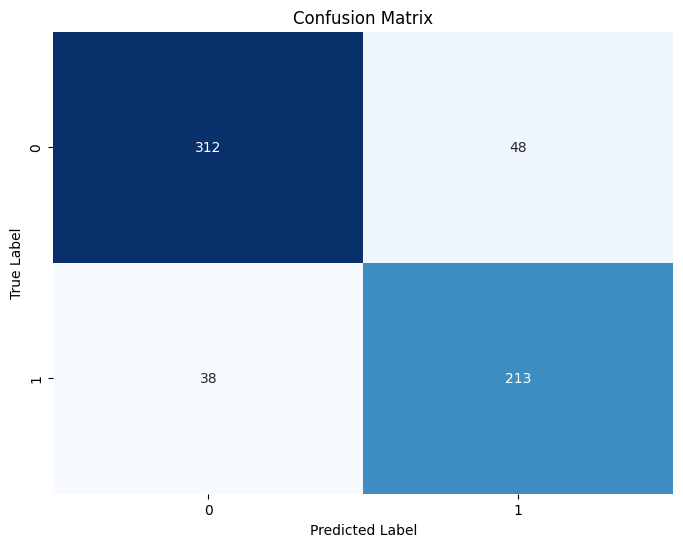

In [82]:
# Loss and Optimizer
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Training loop execution ---
n_epochs = 20
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad() 
        outputs = model(X_batch) 
        loss = criterion(outputs, y_batch) 
        loss.backward() 
        optimizer.step() 
        running_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)

    # --- Evaluation on test set ---
    model.eval() 
    running_test_loss = 0.0
    with torch.no_grad(): 
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_test_loss += loss.item() * X_batch.size(0)
            
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    
    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_train_loss:.4f} - Test Loss: {epoch_test_loss:.4f}")

# Final Evaluation on Test Set
model.eval() 
with torch.no_grad():
    y_pred = model(X_test_tensor) 
    y_pred_label = (y_pred >= 0.5).float() 
    
    # Calculate Metrics
    y_true_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred_label.cpu().numpy()
    
    accuracy = accuracy_score(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np)
    recall = recall_score(y_true_np, y_pred_np)
    f1 = f1_score(y_true_np, y_pred_np)
    cm = confusion_matrix(y_true_np, y_pred_np)
    
print(f"\nFinal Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Conclusion


---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/clandolt/mlcysec_notebooks/)  If you found this tutorial helpful, please **⭐ star our repository** to show your support.   
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/clandolt/mlcysec_notebooks/issues)  For any **questions**, **typos**, or **bugs**, kindly open an issue on GitHub — we appreciate your feedback!

---